# ARIMA Simulation

Thanks to J. Yau

Silicon Valley Data Science

##### May need to enable: jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

from ipywidgets import interactive, widgets, RadioButtons, ToggleButton, Select, FloatSlider, FloatRangeSlider, IntSlider, fixed

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

/Users/jimdoone/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def generate_arima_data(arparams,
                        maparams,
                        i_order=0,
                        n_samp=120,
                        rng_state=None,
                        sigma=1,
                        burnin=10,
                        lin_trend=None,
                        verbose=True,
                        ):
    
    if rng_state is None:
        rng_state = np.random.RandomState()
    ar = np.r_[1, -arparams] # add zero-lag and negate
    ma = np.r_[1, maparams] # add zero-lag
    
    if verbose:
        arma_process = smt.ArmaProcess(ar, ma, nobs=n_samp)
        print('Is the process stationary? {}'.format(arma_process.isstationary))
        print('Is the process invertible? {}'.format(arma_process.isinvertible))

    y = smt.arma_generate_sample(ar, ma, n_samp, sigma=sigma, distrvs=rng_state.randn, burnin=burnin)
    # add deterministic linear trend
    if lin_trend is not None:
        y = y + np.cumsum(np.repeat(lin_trend, n_samp))
    for i in range(i_order):
        y = y.cumsum()
    
    return y

In [3]:
# the function for generating data and plotting
def arima_data(n_samp=120,
               ar_gen=0,
               ar1_coef=0,
               ar2_coef=0,
               ar3_coef=0,
               ar4_coef=0,
               i_gen=0,
               ma_gen=0,
               ma1_coef=0,
               ma2_coef=0,
               ma3_coef=0,
               ma4_coef=0,
               rand_state=42,
               ylim=5,
               ar_fit_p=0,
               i_fit_d=0,
               ma_fit_q=0,
               n_train=108,
               n_forecast=24,
               dynamic=False,
               lin_trend=None,
               verbose=True,
               ):
    
    rng_state = np.random.RandomState(rand_state)

    arparams = np.array([ar1_coef, ar2_coef, ar3_coef, ar4_coef])
    arparams = arparams[:ar_gen]
    maparams = np.array([ma1_coef, ma2_coef, ma3_coef, ma4_coef])
    maparams = maparams[:ma_gen]
    
    print('Generated ARIMA({}, {}, {})'.format(ar_gen, i_gen, ma_gen))
    print('AR coeff = {}, MA coeff = {}'.format(arparams, maparams))
    
    y = generate_arima_data(arparams,
                            maparams,
                            i_gen,
                            n_samp=n_samp,
                            rng_state=rng_state,
                            lin_trend=lin_trend,
                            verbose=verbose,
                            )
    
    # set a fake DatetimeIndex
    df = pd.DataFrame(data=y, columns=['value'], index=pd.date_range(start='1990-01-01', freq='MS', periods=len(y)))
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
    
    ax1.plot(df.iloc[:n_train]['value'], label='In-sample data', linestyle='-')
    # subtract 1 only to connect it to previous point in the graph
    ax1.plot(df.iloc[n_train-1:]['value'], label='Held-out data', linestyle='--')

    fitting=False
    if (((ar_gen > 0) and (ar1_coef != 0)) or ((ma_gen > 0) and (ma1_coef != 0))) and ((ar_fit_p > 0) or (ma_fit_q > 0)):
        fitting=True
        print('Fit ARIMA({}, {}, {})'.format(ar_fit_p, i_fit_d, ma_fit_q))
        
        training = df.iloc[:n_train]['value']
        
        if (lin_trend is not None) and (lin_trend > 0):
            #trend='t'
            
            # there's a bug in statsmodels 0.8.0rc1 regarding trend that has been fixed
            # https://github.com/statsmodels/statsmodels/issues/3111
            trend='n'
        else:
            trend='n'
        model = smt.SARIMAX(training, order=(ar_fit_p, i_fit_d, ma_fit_q),
                            trend=trend,
                            enforce_stationarity=False,
                            enforce_invertibility=False,
                            )
        results = model.fit()
        
        pred_begin = df.index[results.loglikelihood_burn]
        pred_end =  df.index[n_train] + pd.DateOffset(months = n_forecast - 1)
        pred = results.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                      end=pred_end.strftime('%Y-%m-%d'),
                                      dynamic=dynamic)
        pred_mean = pred.predicted_mean
        pred_ci = pred.conf_int(alpha=0.05)
        
        ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
        ax1.fill_between(pred_ci.index,
                         pred_ci.iloc[:, 0],
                         pred_ci.iloc[:, 1], color='k', alpha=.2)
        # plot the residuals
        (df['value'] - pred_mean).dropna().plot(ax=ax2, marker='o')
        ax2.set_xlim((df.index[0], pred_end))
        ax2.set_title('Residuals ($data - model$)');
        ax2.axhline(y=0, linestyle='--', color='k', alpha=.5);
        
    # scale with i_gen
    ylim = ylim*(10**(i_gen))
    ax1.set_ylim((-ylim, ylim));
    ax1.legend(loc='best');
    
    if fitting:
        ax1.fill_betweenx(ax1.get_ylim(), df.index[n_train], pred_end, alpha=.1, zorder=-1)
        ax2.fill_betweenx(ax2.get_ylim(), df.index[n_train], pred_end, alpha=.1, zorder=-1)
        plt.show();
        print(results.summary())
    pass

In [7]:
# set up the widgets
n_samp=120

n_train=108
n_forecast=24

rand_state_init=42
ylim_init=5

# orders
int_min = 0
int_max = 4
int_step = 1

# sliders for data generation
ar_gen_slider = IntSlider(value=0, min=int_min, max=int_max, step=int_step, continuous_update=False)
i_gen_slider = IntSlider(value=0, min=int_min, max=int_max, step=int_step, continuous_update=False)
ma_gen_slider = IntSlider(value=0, min=int_min, max=int_max, step=int_step, continuous_update=False)

# coefficients
lag_min = -1
lag_max = 1
lag_step = 0.1

ar1_coef_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)
ar2_coef_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)
ar3_coef_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)
ar4_coef_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)

ma1_coef_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)
ma2_coef_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)
ma3_coef_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)
ma4_coef_slider = FloatSlider(value=0, min=lag_min, max=lag_max, step=lag_step, continuous_update=False)

rand_slider = IntSlider(value=rand_state_init, min=0, max=10000, step=1, continuous_update=False)
ylim_slider = IntSlider(value=ylim_init, min=1, max=100, step=1, continuous_update=False)

# initial values and sliders for model parameters
ar_fit_p_init=0
i_fit_d_init=0
ma_fit_q_init=0
ar_fit_p_slider = IntSlider(value=ar_fit_p_init, min=int_min, max=int_max, step=int_step, continuous_update=False)
i_fit_d_slider = IntSlider(value=i_fit_d_init, min=int_min, max=int_max, step=int_step, continuous_update=False)
ma_fit_q_slider = IntSlider(value=ma_fit_q_init, min=int_min, max=int_max, step=int_step, continuous_update=False)

# dynamic_init=n_train
# dynamic_slider = IntSlider(value=dynamic_init, min=n_train-10, max=n_train+1, step=int_step, continuous_update=False)

# lin_trend_init = 0
# lin_trend_slider = FloatSlider(value=lin_trend_init, min=0, max=1.0, step=0.1, continuous_update=False)

arima_w = interactive(
    arima_data,
    n_samp=fixed(n_samp),
    ar_gen=ar_gen_slider,
    ar1_coef=ar1_coef_slider,
    ar2_coef=ar2_coef_slider,
    ar3_coef=ar3_coef_slider,
    ar4_coef=ar4_coef_slider,
    i_gen=i_gen_slider,
    ma_gen=ma_gen_slider,
    ma1_coef=ma1_coef_slider,
    ma2_coef=ma2_coef_slider,
    ma3_coef=ma3_coef_slider,
    ma4_coef=ma4_coef_slider,
    rand_state=rand_slider,
    ylim=ylim_slider,
    ar_fit_p=ar_fit_p_slider,
    i_fit_d=i_fit_d_slider,
    ma_fit_q=ma_fit_q_slider,
    n_train=fixed(n_train),
    n_forecast=fixed(n_forecast),
    dynamic=fixed(False),
    #dynamic=dynamic_slider,
    lin_trend=fixed(None),
    #lin_trend=lin_trend_slider,
    verbose=fixed(True),
    )

# arrange the widgets
arima_widget = widgets.HBox([widgets.VBox(arima_w.children[:]),
                             ])
# this is the set of widgets in the function with defaults
arima_widget.on_displayed(lambda x: arima_data(ar_gen=0,
                                                ar1_coef=0,
                                                ar2_coef=0,
                                                ar3_coef=0,
                                                ar4_coef=0,
                                                i_gen=0,
                                                ma_gen=0,
                                                ma1_coef=0,
                                                ma2_coef=0,
                                                ma3_coef=0,
                                                ma4_coef=0,
                                                rand_state=rand_state_init,
                                                ylim=ylim_init,
                                                ar_fit_p=ar_fit_p_init,
                                                i_fit_d=i_fit_d_init,
                                                ma_fit_q=ma_fit_q_init,
                                                n_train=n_train,
                                                #dynamic=dynamic_init,
                                                #lin_trend=lin_trend_init,
                                                ))

Generated ARIMA(0, 0, 0)
AR coeff = [], MA coeff = []
Is the process stationary? True
Is the process invertible? True


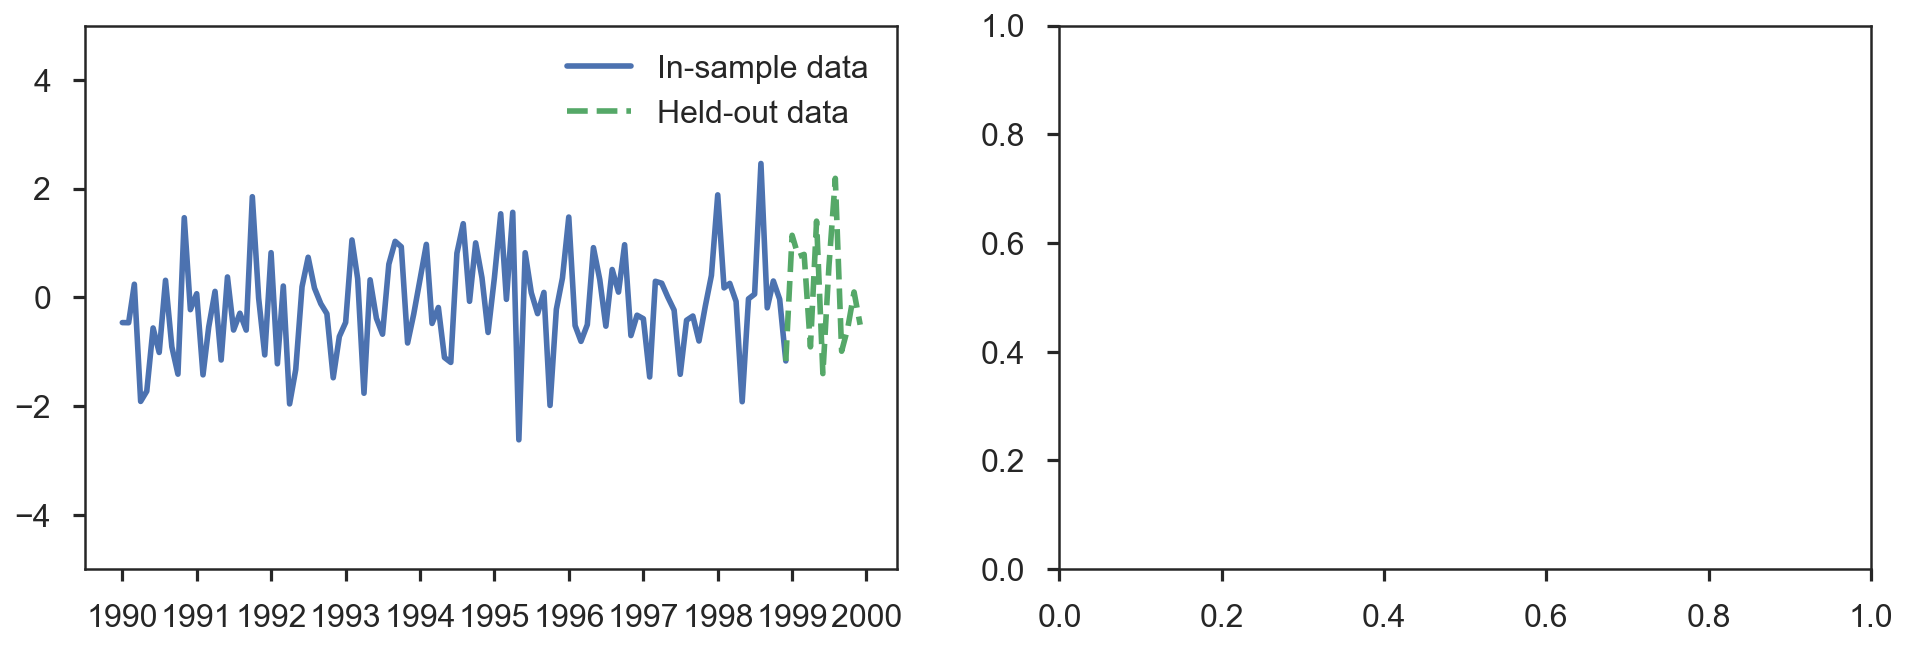

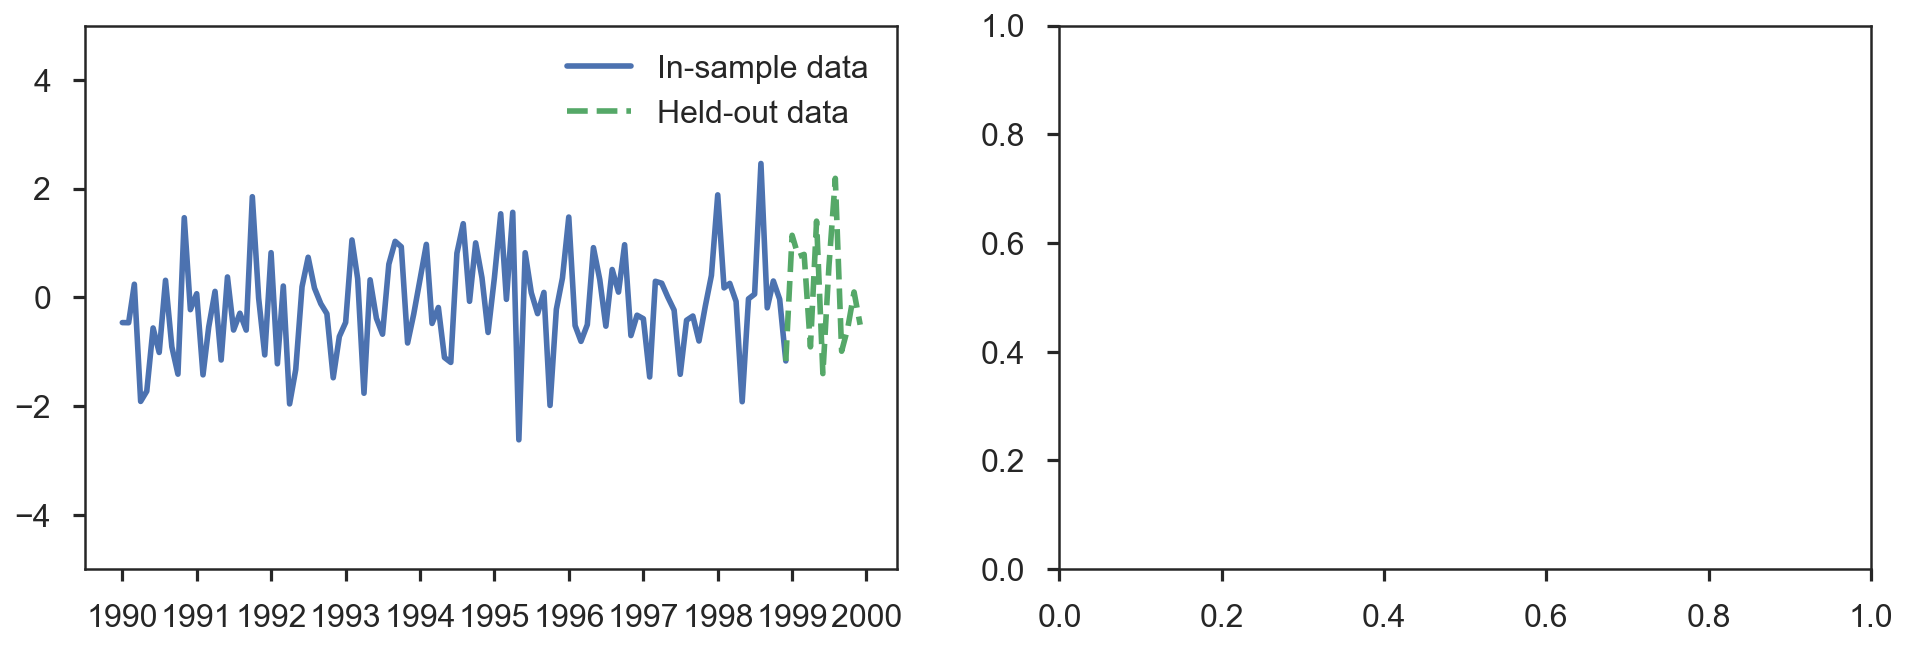

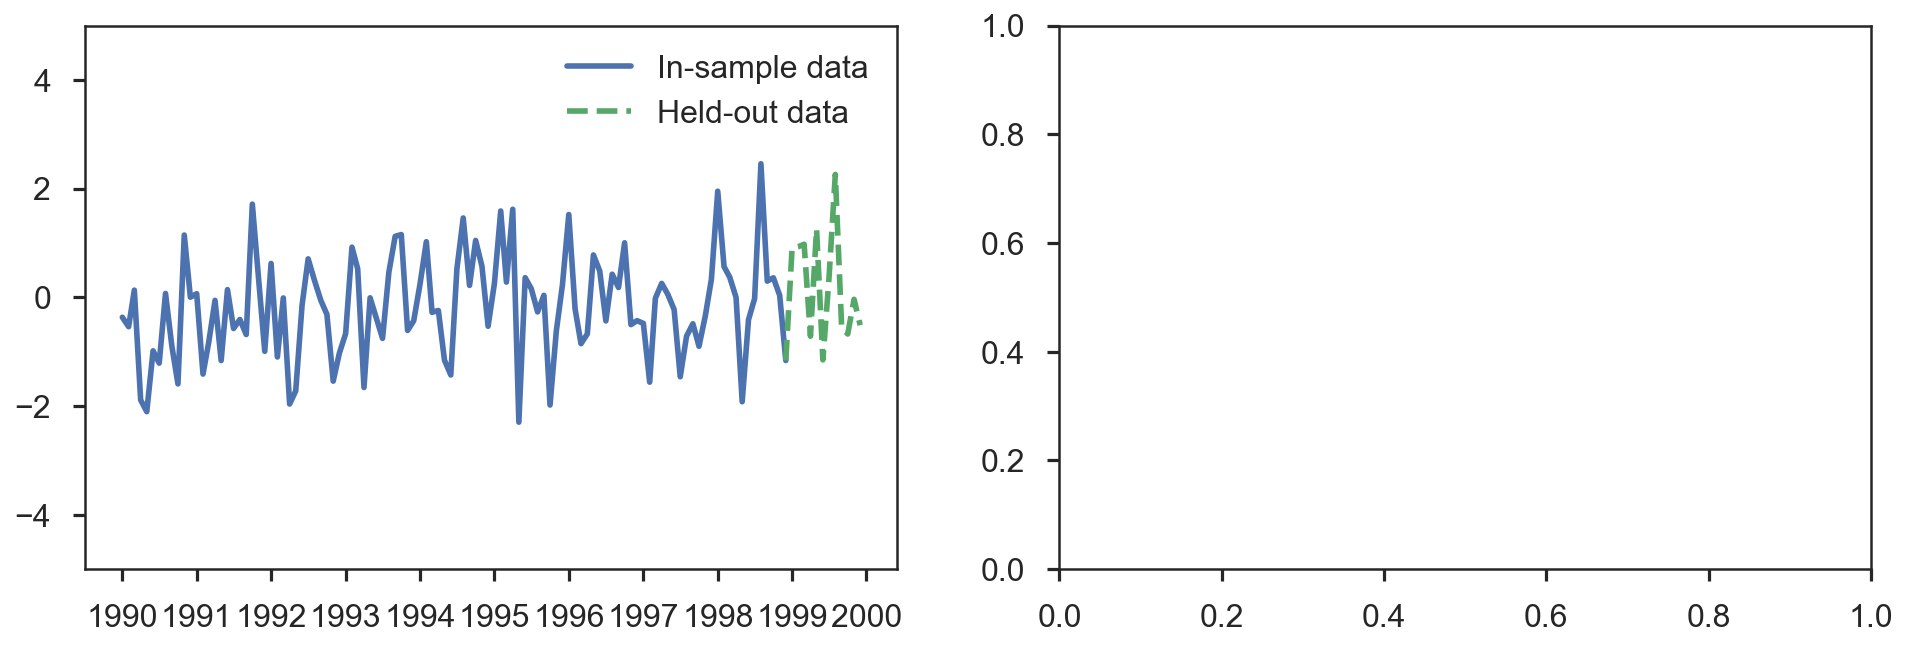

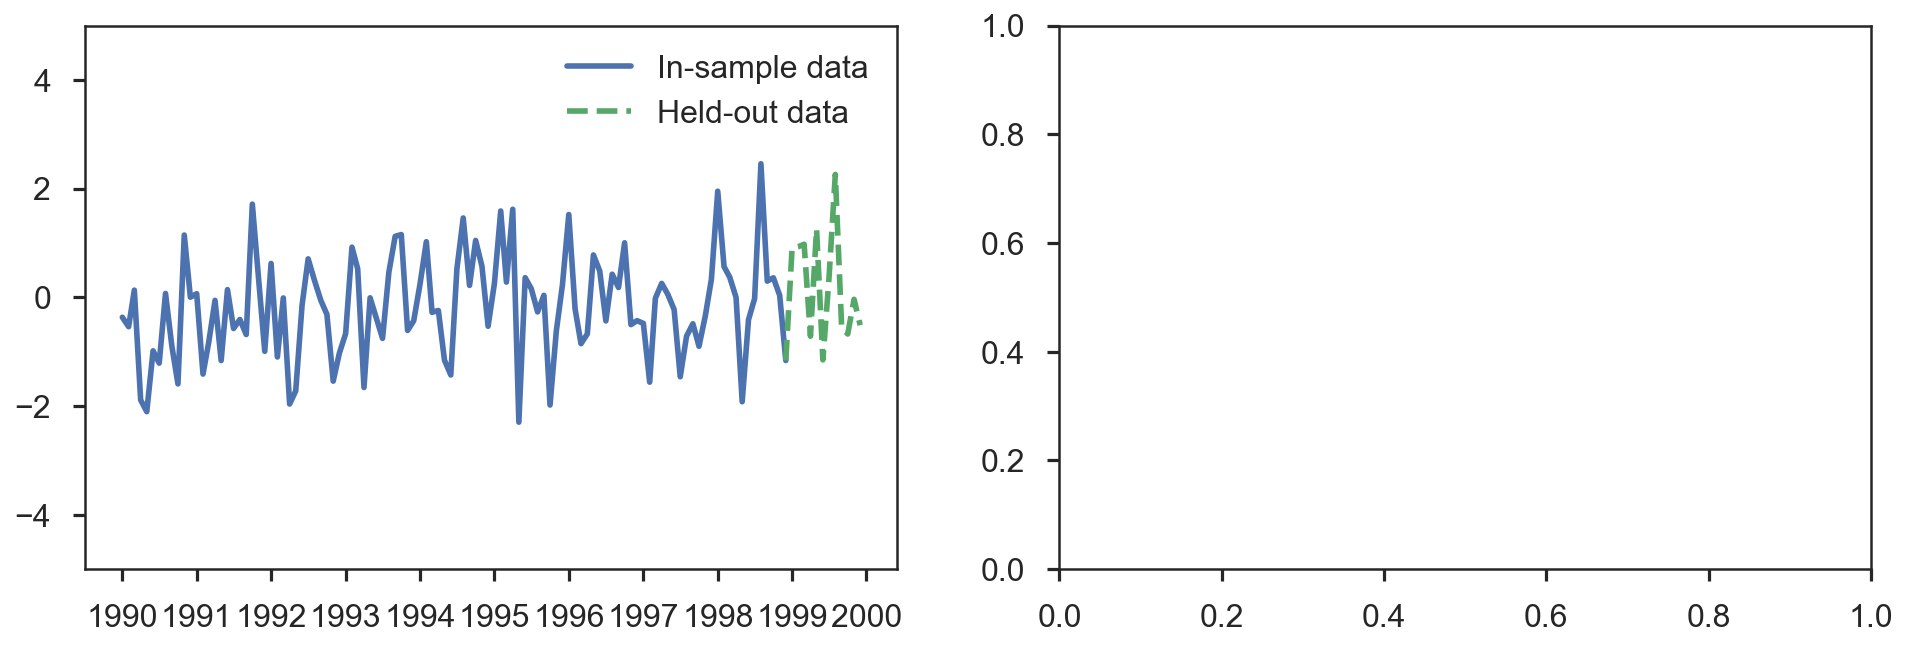

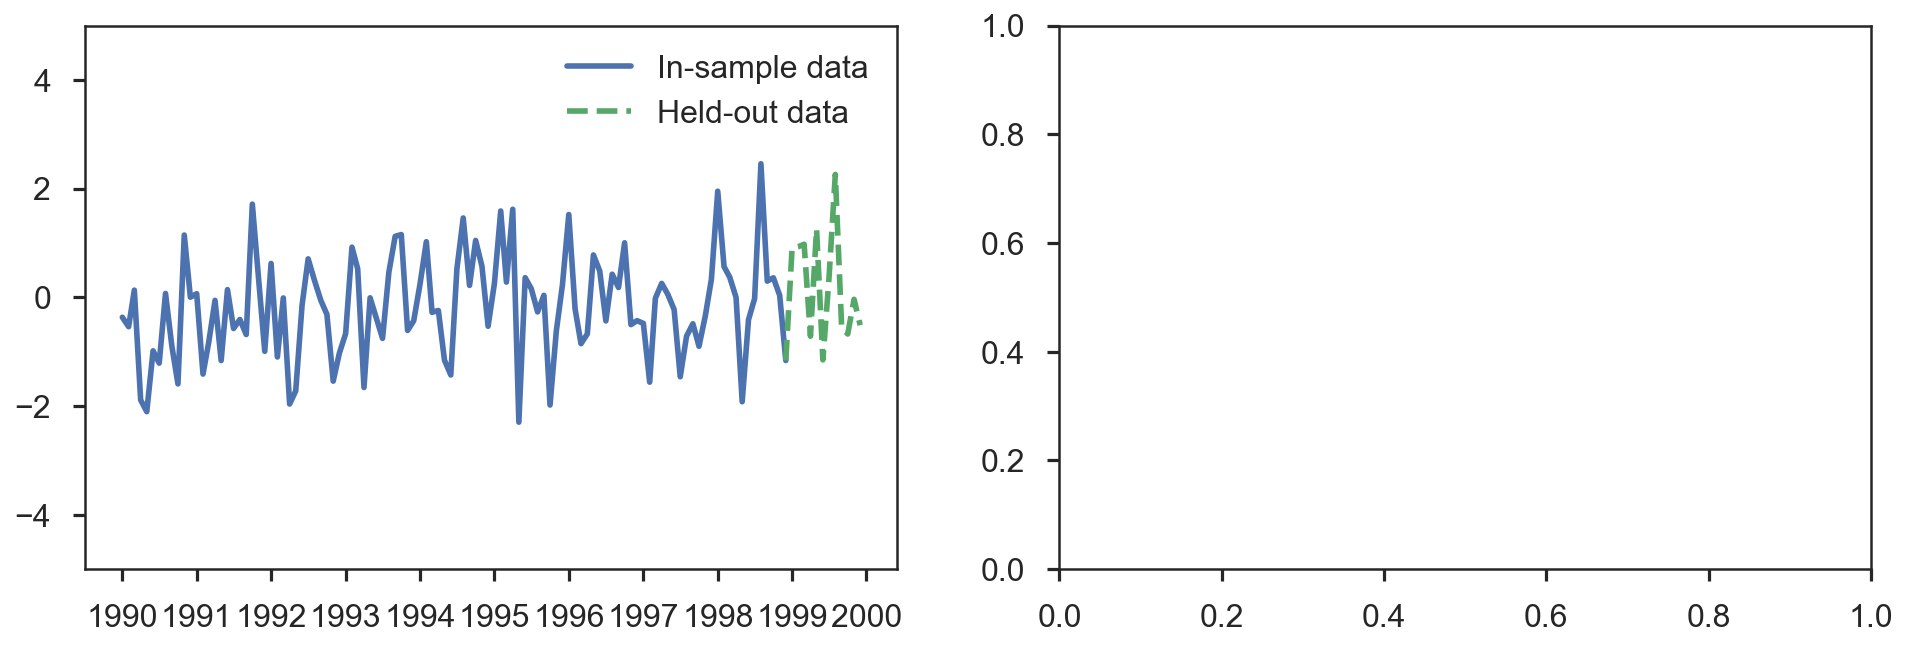

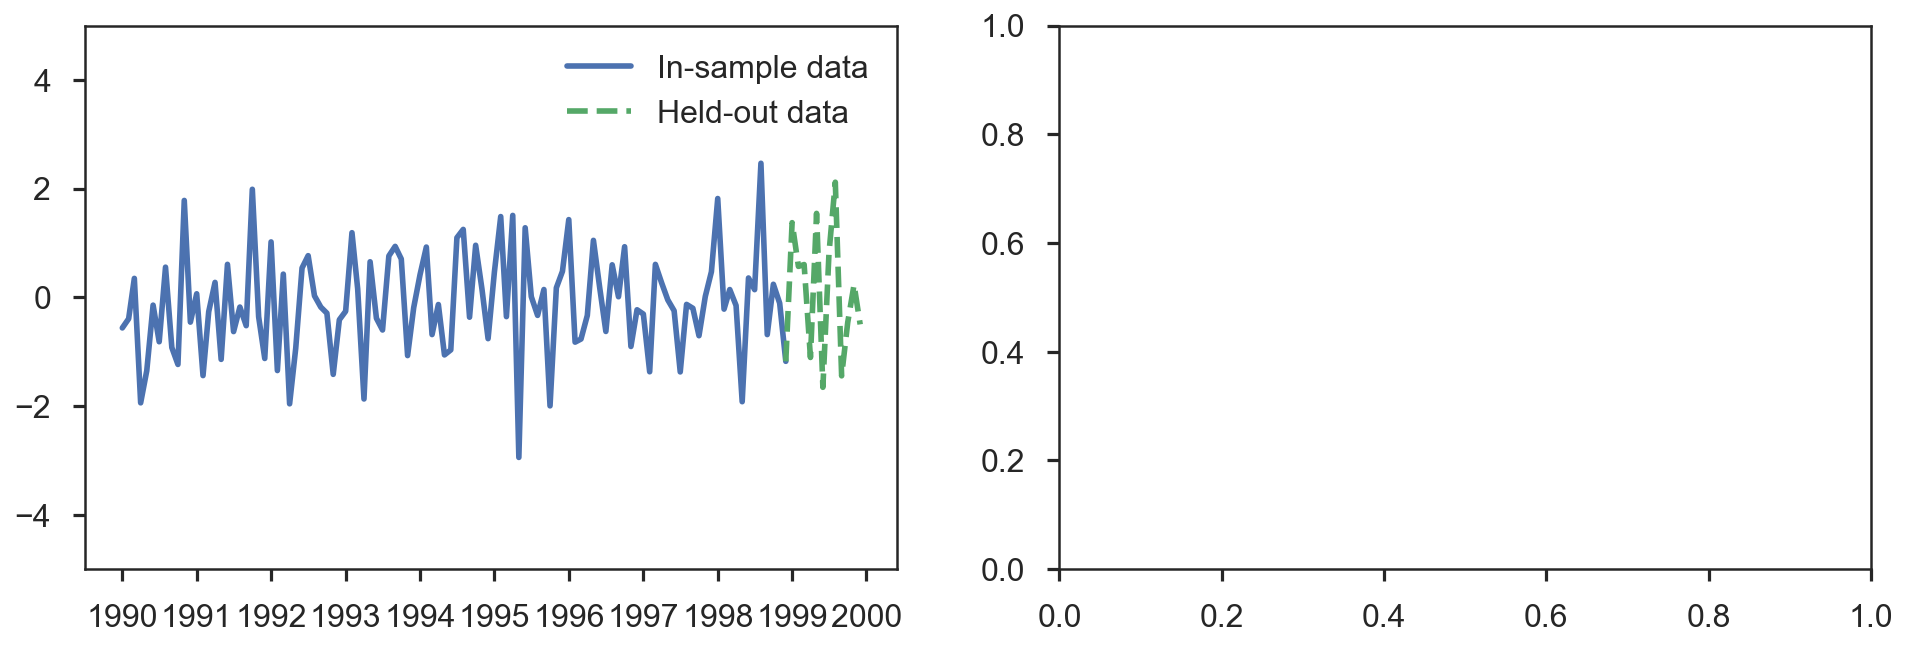

In [8]:
arima_widget